In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import json
import itertools
from pandas.io.json import json_normalize

## INICIO DA COLETA DE DADOS

#### Retorna a categoria do local

In [2]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    return categories_list[0]['name']

#### Informações para acessar a API do foursquare

In [ ]:
CLIENT_ID = '55LWIFZLZNZPSTAZZQKJXBD11BSBCUZTZPIXWVV4RFZJP1HS' # your Foursquare ID
CLIENT_SECRET = 'RPCOWGHQY5YNQUCHQUTC5VLKEYFGZN15FSIYTK5GNXNZ301E' # your Foursquare Secret
VERSION = '20180604'

#### Informações da cidade delimitada

In [ ]:
latitude_nyork = 40.730610
longitude_nyork = -73.935242
radius = 5000
LIMIT = 1000

#### Coleta checkins em bares

In [ ]:
QUERY = 'beer'
url = 'https://api.foursquare.com/v2/venues/search?intent=checkin&query={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    QUERY, CLIENT_ID, CLIENT_SECRET, latitude_nyork, longitude_nyork, VERSION, radius, LIMIT)
results = requests.get(url).json()
bares = results['response']['venues'] 
bares_proximos = json_normalize(bares)
filtered_columns = ['id', 'name', 'categories', 'location.lat', 'location.lng']
bares_proximos = bares_proximos.loc[:, filtered_columns]
bares_proximos['categories'] = bares_proximos.apply(get_category_type, axis=1)
bares_proximos.columns = [col.split(".")[-1] for col in bares_proximos.columns]
bares_proximos.tail(10)

#### Pega as pessoas que deram checkins nos locais

In [ ]:
checkins_bares = pd.DataFrame()
for bar in bares_proximos.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}&limit={}'.format(
    bar[1]['id'], CLIENT_ID, CLIENT_SECRET, VERSION, 2000)
    results = requests.get(url).json()
    if (results['response']['likes']['count'] > 0) & ('items' in results['response']['likes']):
        results_2 = results['response']['likes']['items']
        checkins = json_normalize(results_2)[['id', 'firstName', 'gender']]
        checkins['avenue_id'] = bar[1]['id']
        checkins['avenue_name'] = bar[1]['name']
        checkins['avenue_categories'] = bar[1]['categories']
        checkins['avenue_lat'] = bar[1]['lat']
        checkins['avenue_lng'] = bar[1]['lng']
        if checkins_bares.empty:
            checkins_bares = checkins
        else:
            checkins_bares = pd.concat([checkins_bares, checkins], ignore_index=True)

#### Salva os checkins encontrados

In [ ]:
checkins_bares.to_csv('victor_bares_checkins.csv', index=False)

## FINAL DA COLETA DE DADOS

## INICIO DA CRIACAO DO GRAFO

#### Lê os checkins coletados

In [2]:
checkins_bares = pd.read_csv('victor_bares_checkins.csv', encoding = 'utf8')

In [3]:
checkins_bares.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng
8746,222574700,Kayla,female,565cbec4498e7ec1b08e8182,Norwinds Beer Garden,Beer Garden,40.704114,-73.930618
8747,20635813,Victor,male,57339ff5498ebbf28b9eb4a2,Beer Garden Dazzler Brooklyn Hotel,Beer Garden,40.696674,-73.984278
8748,44828230,Ipek,female,57339ff5498ebbf28b9eb4a2,Beer Garden Dazzler Brooklyn Hotel,Beer Garden,40.696674,-73.984278
8749,16359325,Gokhan,male,57339ff5498ebbf28b9eb4a2,Beer Garden Dazzler Brooklyn Hotel,Beer Garden,40.696674,-73.984278
8750,435922162,Edna,female,57339ff5498ebbf28b9eb4a2,Beer Garden Dazzler Brooklyn Hotel,Beer Garden,40.696674,-73.984278


#### Pegar os 5 bares com mais checkins

In [4]:
checkins_bares_value_counts = checkins_bares['avenue_id'].value_counts()
checkins_bares_value = checkins_bares_value_counts[:5].index

In [5]:
checkins_locais = list(checkins_bares_value)

#### Pega os checkins apenas desses locais

In [6]:
checkins_completo = checkins_bares[checkins_bares['avenue_id'].isin(checkins_locais)]

In [7]:
checkins_completo.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng
8017,9857,Pete,male,40870b00f964a520b7f21ee3,Loreley Beer Garden,Beer Garden,40.721128,-73.993049
8018,57286,Joe,male,40870b00f964a520b7f21ee3,Loreley Beer Garden,Beer Garden,40.721128,-73.993049
8019,21105649,Emily,female,40870b00f964a520b7f21ee3,Loreley Beer Garden,Beer Garden,40.721128,-73.993049
8020,2102,Kushal,male,40870b00f964a520b7f21ee3,Loreley Beer Garden,Beer Garden,40.721128,-73.993049
8021,32,Dens,male,40870b00f964a520b7f21ee3,Loreley Beer Garden,Beer Garden,40.721128,-73.993049


#### Pega os IDs dos usuarios únicos

In [8]:
usuarios_unicos = list(checkins_completo['id'].drop_duplicates())

#### Cria um grafo e adiciona os nós do tipo PESSOA, BAR e SORVETERIA

In [32]:
G = nx.Graph()

In [33]:
for bar in checkins_bares_value:
    G.add_node(bar, 
               nome=checkins_completo[checkins_completo['avenue_id']==bar]['avenue_name'].values[0],
               tipo='BAR',
               cor=0.2)

In [34]:
for usuarios in usuarios_unicos:
    G.add_node(usuarios, 
               nome=checkins_completo[checkins_completo['id']==usuarios]['firstName'].values[0],
               genero=checkins_completo[checkins_completo['id']==usuarios]['gender'].values[0],
               tipo='PESSOA',
               cor=1.0)

#### Adiciona as ligações entre os nós, casa um usuário deu checkin num bar ou sorveteria

In [35]:
for local in checkins_locais:
    for i,checkin in checkins_completo[checkins_completo['avenue_id']==local].iterrows():
        G.add_edge(checkin['id'], local, weight=1)

#### Salva o grafo

In [36]:
nx.write_gml(G, 'grafo_analise_final_bares.gml')

## FINAL DA CRIAÇÃO DO GRAFO

## INICIO DA ANALISE

In [37]:
grafo = nx.read_gml('grafo_analise_final_bares.gml')

In [38]:
[n for n in grafo.nodes(data=True)][:3]

[('3fd66200f964a52008f11ee3',
  {'nome': 'Bohemian Hall & Beer Garden', 'tipo': 'BAR', 'cor': 0.2}),
 ('4ff74eeae4b0f08304f382fc',
  {'nome': 'The Jeffrey Craft Beer & Bites', 'tipo': 'BAR', 'cor': 0.2}),
 ('40870b00f964a520b7f21ee3',
  {'nome': 'Loreley Beer Garden', 'tipo': 'BAR', 'cor': 0.2})]

In [39]:
[n for n in grafo.edges(data=True)][:3]

[('3fd66200f964a52008f11ee3', '123557238', {'weight': 1}),
 ('3fd66200f964a52008f11ee3', '91747140', {'weight': 1}),
 ('3fd66200f964a52008f11ee3', '42407406', {'weight': 1})]

#### Plota o grafo
* AZUL: Pessoas
* Vermelho: Bares

(-0.9540358464180678,
 0.9082057218563833,
 -1.063710776810886,
 1.0994593937011345)

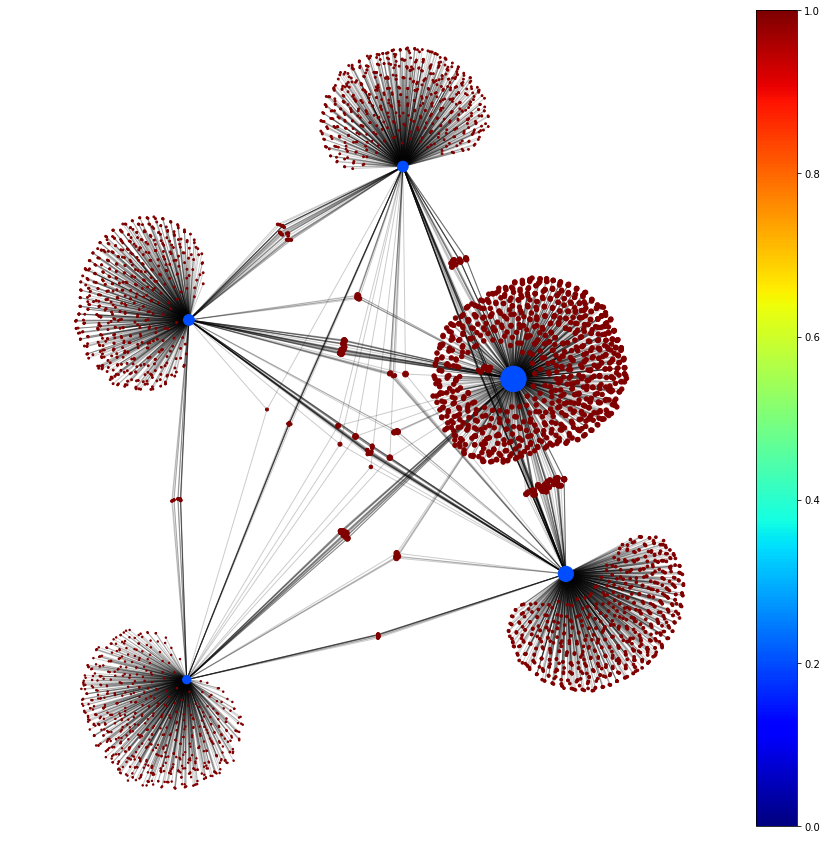

In [40]:
pos = nx.spring_layout(grafo)
centralidades = nx.eigenvector_centrality_numpy(grafo, weight='weight')
node_color = [v['cor'] for i,v in grafo.nodes(data=True)]
node_size = [v * 1000 for v in centralidades.values()]
plt.figure(figsize=(15,15))
ed = nx.draw_networkx_edges(grafo, pos=pos, alpha=0.2)
no = nx.draw_networkx_nodes(grafo, pos=pos, with_labels=False, node_color=node_color, 
                            cmap=cm.jet, vmin=0.0, vmax=1.0,
                            node_size=node_size)
plt.colorbar(no)
plt.axis('off')